<a href="https://colab.research.google.com/github/abdelrahemhagagrefaeeamen/deep_learning11/blob/main/Copy_of_FinalDeeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
car-vs-bike-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Basic
import os
from os import listdir
import numpy as np
import pandas as pd
import zipfile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Specify the path to the zip file containing the dataset and the extraction location
train_file_path = "/content/car-vs-bike-classification-dataset.zip"  # Replace with the actual path to the dataset zip file
files = "/content"  # Replace with the path to the folder where files will be extracted

# Open the zip file and extract all its contents
with zipfile.ZipFile(train_file_path, 'r') as zip_file:
    zip_file.extractall(files)  # Extract files to the specified folder


main_dir = "/content/Car-Bike-Dataset"
folders = os.listdir(main_dir)
files_paths = []
labels = []
for folder in folders:
    fold_path = os.path.join(main_dir, folder)
    files = os.listdir(fold_path)
    for file in files:
        file_path = os.path.join(fold_path, file)
        files_paths.append(file_path)
        labels.append(folder)
df = pd.DataFrame({"File Path": files_paths, "Labels": labels})
df.head(10)

,File Path,Labels
0,/content/Car-Bike-Dataset/Car/Car (1703).jpeg,Car
1,/content/Car-Bike-Dataset/Car/Car (1338).jpeg,Car
2,/content/Car-Bike-Dataset/Car/Car (1898).jpeg,Car
3,/content/Car-Bike-Dataset/Car/Car (1460).jpeg,Car
4,/content/Car-Bike-Dataset/Car/Car (332).jpeg,Car
5,/content/Car-Bike-Dataset/Car/Car (322).jpeg,Car
6,/content/Car-Bike-Dataset/Car/Car (1726).jpeg,Car
7,/content/Car-Bike-Dataset/Car/Car (1194).jpeg,Car
8,/content/Car-Bike-Dataset/Car/Car (992).jpeg,Car
9,/content/Car-Bike-Dataset/Car/Car (507).jpeg,Car


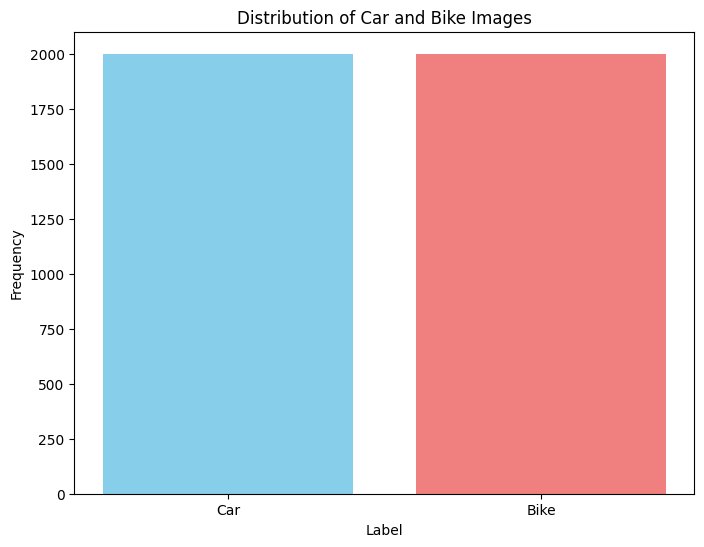

In [ ]:
# @title Distribution of Car and Bike Images

import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'df'
label_counts = df['Labels'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral'])
plt.title('Distribution of Car and Bike Images')
plt.xlabel('Label')
plt.ylabel('Frequency')
_ = plt.xticks(rotation=0)




[ 131 3499  336 3580 1447 3842 3303 1400  808 2744   54  410  968 3148
 3394  693]


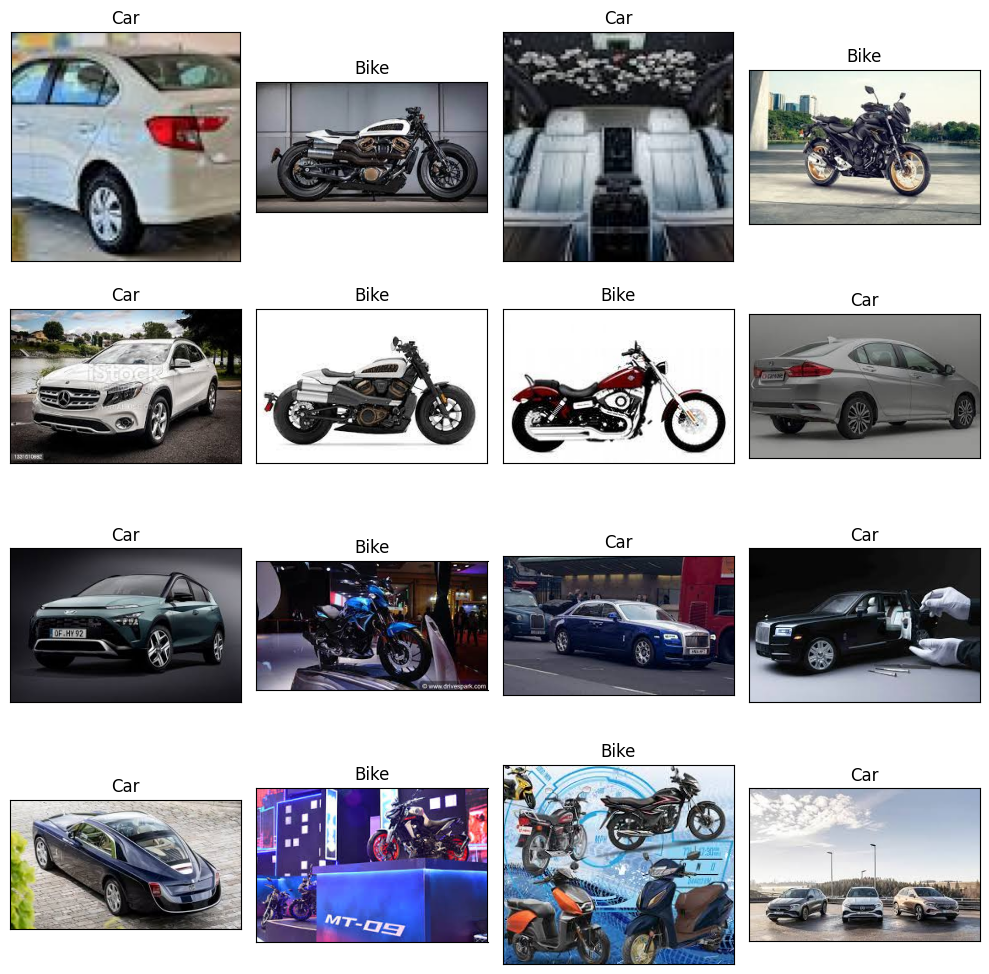

In [ ]:
 # Ensure labels are horizontal

random_index = np.random.randint(0, len(df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File Path"][random_index[i]])) # Use "File Path" instead of "Filepath"
    ax.set_title(df.Labels[random_index[i]]) # Use "Labels" instead of "Label"
plt.tight_layout()
plt.show()

In [ ]:
# Split data into training (80%) and test (20%) sets
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Print the shapes of the resulting datasets
print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)

The shape of train data (3200, 2)
The shape of test data (800, 2)


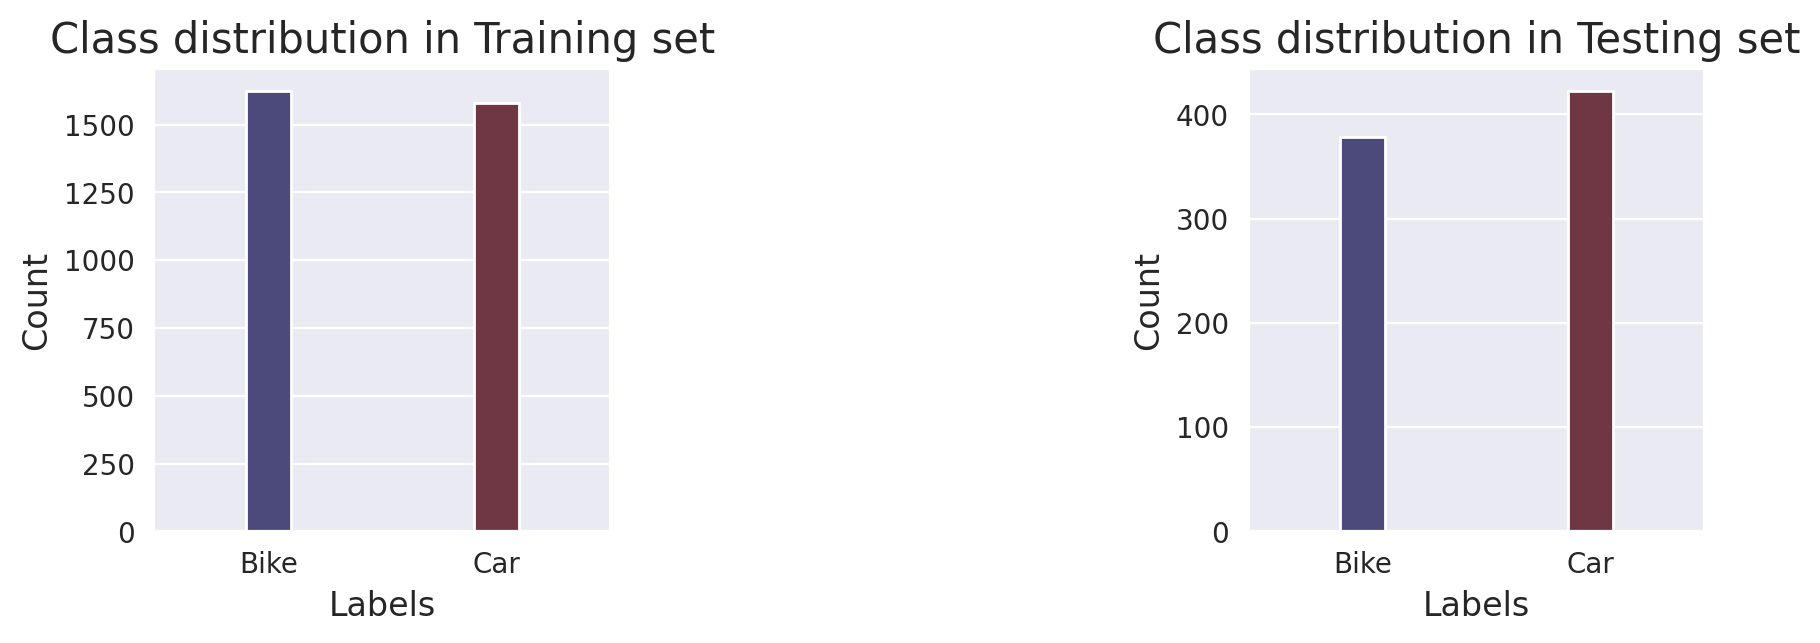

In [ ]:
labels = ['Bike','Car']  # Assuming 'Bike' and 'Car' are your actual labels

label1, count1 = np.unique(X_train['Labels'], return_counts=True) # Access 'Labels' column using bracket notation
label3, count3 = np.unique(X_test['Labels'], return_counts=True) # Access 'Labels' column using bracket notation

uni1 = pd.DataFrame(data=count1, index=labels, columns=['Count1'])
uni3 = pd.DataFrame(data=count3, index=labels, columns=['Count3'])

plt.figure(figsize=(10,3),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

In [ ]:
image_size = (224, 224)  # Image size
image_channel = 3  # Number of color channels
batch_size = 32  # Batch size for training the model

In [ ]:
# Create ImageDataGenerator for training without augmentation
train_datagen = ImageDataGenerator(rescale=1./255
                                   )  # Only normalize image pixels to the range 0-1

# Create ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize image pixels to the range 0-1 for testing

In [ ]:
# Split data into training (80%) and test (20%) sets
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Further split training data into training (80%) and validation (20%) sets
X_train, X_val = train_test_split(X_train, test_size=0.2, shuffle=True, random_state=42) # Split X_train into train and validation

# Print the shapes of the resulting datasets
print('The shape of train data', X_train.shape)
print('The shape of validation data', X_val.shape)
print('The shape of test data', X_test.shape)

# ... (Rest of your code remains the same, including the generators) ...

The shape of train data (2560, 2)
The shape of validation data (640, 2)
The shape of test data (800, 2)


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load the VGG19 model with pre-trained weights
pretrained_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers to retain the features learned
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new custom layers on top of the VGG19 backbone
x = layers.GlobalAveragePooling2D()(pretrained_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output

# Define the final model
model = Model(inputs=pretrained_model.input, outputs=x)

In [ ]:
# Compile the model with the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Correct loss for binary classification
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("vgg19_car_bike_model.keras", save_best_only=True)

model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.6127 - loss: 3.8824 - val_accuracy: 0.9325 - val_loss: 3.2249
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.7969 - loss: 3.0827 - val_accuracy: 0.9550 - val_loss: 2.5776
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.8775 - loss: 2.4867 - val_accuracy: 0.9475 - val_loss: 2.0857
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9184 - loss: 2.0122 - val_accuracy: 0.9550 - val_loss: 1.6948
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.9377 - loss: 1.6377 - val_accuracy: 0.9588 - val_loss: 1.3885
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.9356 - loss: 1.3492 - val_accuracy: 0.9563 - val_loss: 1.1488
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9408 - loss: 1.1205 - val_accuracy: 0.9563 - val_loss: 0.9605
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.9469 - loss: 0.9425 - val_accu

In [ ]:
# Retrieve final training accuracy and loss
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
# Validation set Accuracy
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluate the model on the testing set using the test_generator
test_loss, test_acc = model.evaluate(test_generator)  # Use test_generator instead of test_images
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

Final Training Accuracy: 0.9566
Final Training Loss: 0.3118
Final Validation Accuracy: 0.9638
Final Validation Loss: 0.2861
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9628 - loss: 0.2912
Testing Accuracy: 0.9638
Testing Loss: 0.2861


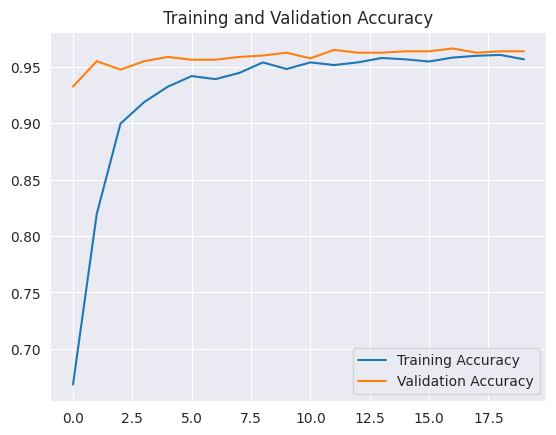

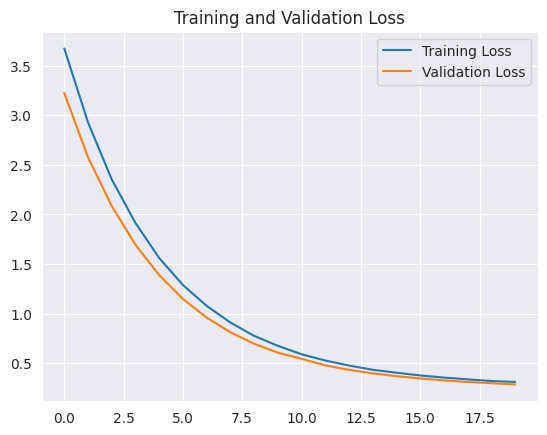

In [ ]:
#  Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(history.history['loss']))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step
Classification Report:
              precision    recall  f1-score   support

        Bike       0.97      0.96      0.96       378
         Car       0.96      0.97      0.97       422

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



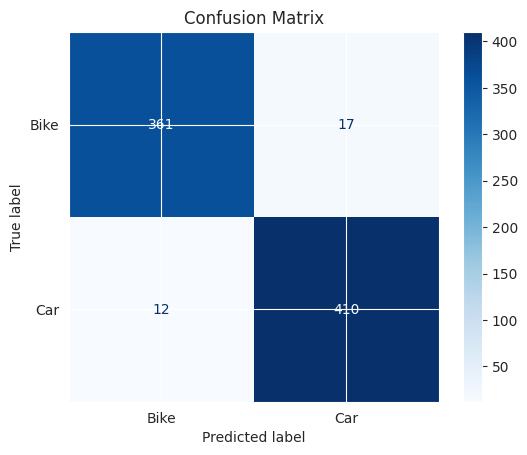

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the test dataset
y_pred_probs = model.predict(test_generator)  # Predict probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Extract true labels
y_true = test_generator.classes  # Get true labels from the generator

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()